In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os, json
from PIL import Image
from tqdm import tqdm
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

%matplotlib inline

### Image resolution
- Maximum 500
- Minimum 128
- Only approximately 120 images from 8000 in total that have resolution less than 256
- ***Setting resolution to 256x256 maybe a good choice.***

<br />

### Transfer learning choices
EfficientNet becoming the best choice because they have high accuracy with fewer parameters
- EfficientNetB0 (224, 224, 3) *** --> We will use this one.
- EfficientNetB1 (240, 240, 3)
- EfficientNetB2 (260, 260, 3)
- EfficientNetB3 (300, 300, 3)
- EfficientNetB4 (380, 380, 3)

In [2]:
# img_path = path to folder of image
# json_path = path to karpathy's json file ## dataset choices

img_path = 'dataset/Flicker8k_Dataset/'
json_path = 'caption_datasets/dataset_flickr8k.json'

In [3]:
from source.utils import prepare_data, Create_image_caption_pair
from source.Dataset import ImgCaption_Dataset

In [4]:
# Split dataset
train_img, train_cap, val_img, val_cap, test_img, test_cap, vocab_dict = prepare_data(img_path, json_path, 5)

In [5]:
# This function Create image_path and caption Encoding pair for any split
# Note that this function map caption word to token ("a dog is playing" --> [1, 4, 5, 8, 132, 2])
train_X, train_Y, train_caplen, trian_capidx = Create_image_caption_pair(train_img, train_cap, vocab_dict, 25)
val_X, val_Y, val_caplen, val_capidx = Create_image_caption_pair(val_img, val_cap, vocab_dict, 25)
test_X, test_Y, test_caplen, test_capidx = Create_image_caption_pair(test_img, test_cap, vocab_dict, 25)

In [6]:
# Define Image transformation
# Since we using pretrained from ImageNet, Normalization mean and std are also from ImageNet.
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([transforms.Resize((256,256)),
                                transforms.RandomHorizontalFlip(0.5),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

# Get pair from Custom Datset
train_data = ImgCaption_Dataset(train_X, train_Y, train_caplen, trian_capidx, transform)
valid_data = ImgCaption_Dataset(val_X, val_Y, val_caplen, val_capidx, transform)
test_data = ImgCaption_Dataset(test_X, test_Y, test_caplen, test_capidx, transform)

# pytorch Dataloader
train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset=valid_data, batch_size=32, shuffle=False, pin_memory=True)
test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False, pin_memory=True)

In [7]:
# Just Testing function
data = next(iter(train_loader))

In [8]:
def denormalize(img ,mean, std):
    img[0, :, :] = (img[0, :, :] * std[0]) + mean[0]
    img[1, :, :] = (img[1, :, :] * std[1]) + mean[1]
    img[2, :, :] = (img[2, :, :] * std[2]) + mean[2]
    return img

def get_caption_back(token, vocab):
    caption = ""
    for tok in token:
        if tok == 1:
            continue
        if tok == 2:
            break
        word = list(vocab_dict.keys())[list(vocab_dict.values()).index(tok)]
        caption += str(word) + " "
    return caption

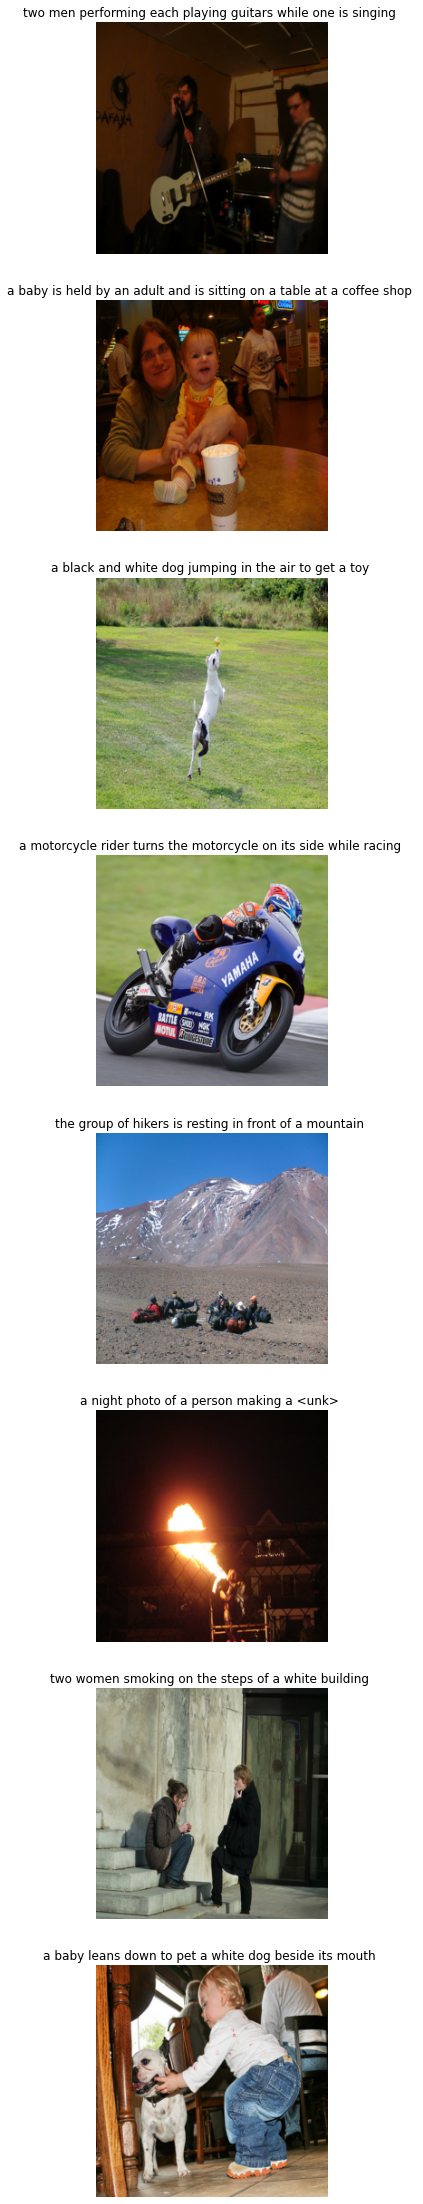

In [9]:
fig, ax = plt.subplots(8, 1, figsize=(40,40))
for i in range(8):
    img = denormalize(np.array(data[0][i]), mean, std)
    ax[i].set_title(get_caption_back(data[1][i], vocab_dict))
    ax[i].axis('off')
    ax[i].imshow(np.moveaxis(img, 0, -1))
plt.show()

# Models exploration
<br>

#### Attention:
- Encoder-DecoderWithAttention
- Encoder --> CNN (Pretrained backbone)
- Decoder --> GRU (Input is concat of word+imageAttention)


In [10]:
import torchvision.models as models
from torch import nn
from tqdm import tqdm

from source.models.Attention import Encoder, AttentionDecoder # import model
from source.helper import train, evaluate # import helper function

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [11]:
# initialize parameters 
TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 16 # this is a limitation for inference time
EPOCH = 20

device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = {
    "target_pixel": 16,
    "latent_size": 512,
    "hidden_layer": 512,
    "vocab_size": len(vocab_dict),
    "lr": 0.005
}

In [12]:
train_loader = DataLoader(dataset=train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=3, prefetch_factor=3)
val_loader = DataLoader(dataset=valid_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(dataset=test_data, batch_size=TEST_BATCH_SIZE, shuffle=True, pin_memory=True)

In [13]:
# Backbone
# Pretrained model is our choices.
effnet = models.efficientnet_b2(pretrained=True)

In [14]:
# Define model
encoder = Encoder(effnet, config["latent_size"]).to(device)
decoder = AttentionDecoder(config["latent_size"], 512, 256, 512, config["vocab_size"]).to(device)

In [15]:
from torchinfo import summary

summary(encoder, (1, 3, 256, 256))

Layer (type:depth-idx)                                       Output Shape              Param #
Encoder                                                      --                        --
├─Sequential: 1-1                                            [1, 1408, 8, 8]           --
├─EfficientNet: 1                                            --                        --
│    └─Sequential: 2-1                                       [1, 1408, 8, 8]           --
│    │    └─ConvNormActivation: 3-1                          [1, 32, 128, 128]         (928)
│    │    └─Sequential: 3-2                                  [1, 16, 128, 128]         (2,060)
│    │    └─Sequential: 3-3                                  [1, 24, 64, 64]           (27,424)
│    │    └─Sequential: 3-4                                  [1, 48, 32, 32]           (103,134)
│    │    └─Sequential: 3-5                                  [1, 88, 16, 16]           (421,550)
│    │    └─Sequential: 3-6                                  [1, 12

In [16]:
criterion = nn.CrossEntropyLoss()

"""params = list(decoder.parameters()) + \
        list(encoder.latent1.parameters()) + \
        list(encoder.latent2.parameters()) + \
        list(encoder.batchnorm1.parameters()) + \
        list(encoder.batchnorm2.parameters())"""
# Note that encoder has no any learnable parameters since we use freeze pretrained.
optimizer = torch.optim.AdamW(params=filter(lambda p: p.requires_grad, decoder.parameters()),
                              lr=config["lr"])

this_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                               'max',
                                                               patience=3,
                                                               factor=0.1,
                                                               min_lr=1e-8) 

In [17]:
best_val = 0
os.makedirs('weights', exist_ok=True)
best_enc_path = 'weights/best_enc_path.pth' 
best_dec_path = 'weights/best_dec_path.pth' 
for epoch in range(EPOCH):
    print("On Epoch: ", epoch+1, " . . .")
    loss = train(encoder, decoder, device, train_loader, optimizer, criterion, log_interval=50)
    val_bleu4 = evaluate(encoder, decoder, device, val_loader, vocab_dict, val_cap)
    print("Validation BLEU : ", val_bleu4, "\n")
    if val_bleu4 > best_val:
        best_val = val_bleu4
        print("### New best model found, Saving model . . .")
        torch.save(encoder.state_dict(), best_enc_path)
        torch.save(decoder.state_dict(), best_dec_path)
    this_scheduler.step(val_bleu4)

On Epoch:  1  . . .
Train step [0 / 468], loss :  7.816173076629639
Train step [50 / 468], loss :  3.9565269947052
Train step [100 / 468], loss :  3.843923568725586
Train step [150 / 468], loss :  3.494300127029419
Train step [200 / 468], loss :  3.5251917839050293
Train step [250 / 468], loss :  3.519643783569336
Train step [300 / 468], loss :  3.2691307067871094
Train step [350 / 468], loss :  3.3097827434539795
Train step [400 / 468], loss :  3.3253700733184814
Train step [450 / 468], loss :  3.2126708030700684
Validation BLEU :  0.10977221989966099 

### New best model found, Saving model . . .
On Epoch:  2  . . .
Train step [0 / 468], loss :  2.8661861419677734
Train step [50 / 468], loss :  2.921900749206543
Train step [100 / 468], loss :  3.0258374214172363
Train step [150 / 468], loss :  3.1736252307891846
Train step [200 / 468], loss :  3.1908633708953857
Train step [250 / 468], loss :  3.1932756900787354
Train step [300 / 468], loss :  2.978917121887207
Train step [350 / 468]

Train step [150 / 468], loss :  1.6101888418197632
Train step [200 / 468], loss :  1.6811422109603882
Train step [250 / 468], loss :  1.65701162815094
Train step [300 / 468], loss :  1.5816720724105835
Train step [350 / 468], loss :  1.5939457416534424
Train step [400 / 468], loss :  1.6072678565979004
Train step [450 / 468], loss :  1.650351881980896
Validation BLEU :  0.13185458768389027 

On Epoch:  16  . . .
Train step [0 / 468], loss :  1.6447895765304565
Train step [50 / 468], loss :  1.6599295139312744
Train step [100 / 468], loss :  1.6125885248184204
Train step [150 / 468], loss :  1.5779346227645874
Train step [200 / 468], loss :  1.6012756824493408
Train step [250 / 468], loss :  1.6632150411605835
Train step [300 / 468], loss :  1.6290395259857178
Train step [350 / 468], loss :  1.6335738897323608
Train step [400 / 468], loss :  1.7318300008773804
Train step [450 / 468], loss :  1.6493608951568604
Validation BLEU :  0.09706401929455837 

On Epoch:  17  . . .
Train step [0 /

In [18]:
# Load best model for inference
best_enc_path = 'weights/best_enc_path.pth' 
best_dec_path = 'weights/best_dec_path.pth' 
encoder.load_state_dict(torch.load(best_enc_path))
decoder.load_state_dict(torch.load(best_dec_path))

<All keys matched successfully>

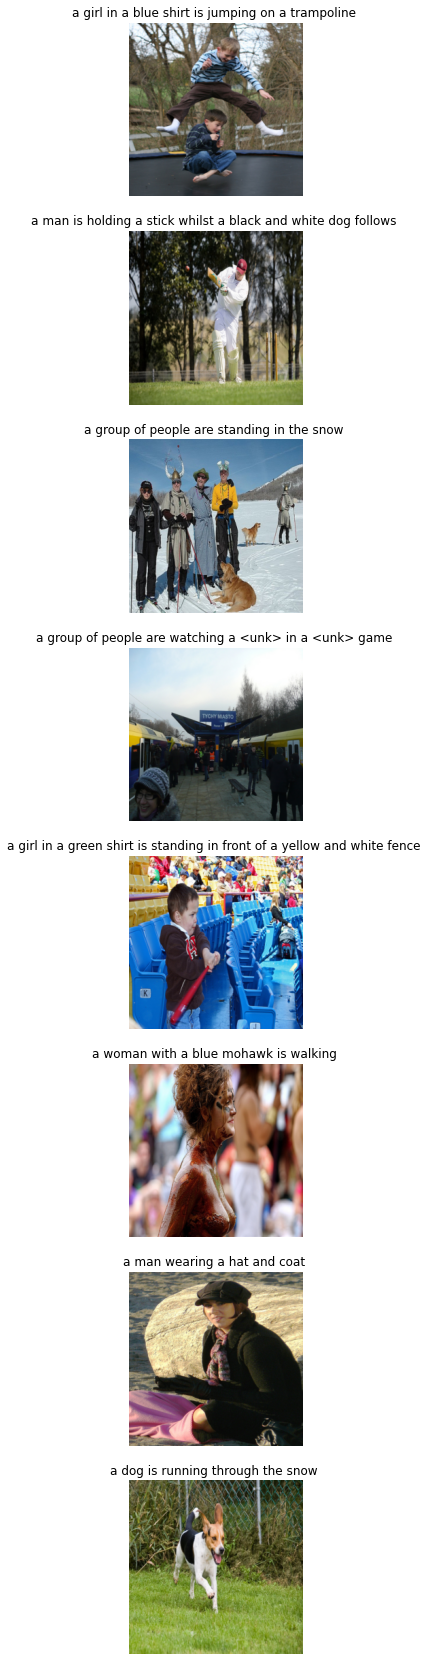

In [60]:
# Get Prediction from validation set
test_data = next(iter(test_loader))
encoder.eval()
decoder.eval()
with torch.no_grad():
    x = encoder(test_data[0].cuda())
    # At inference time, input should be only img latent.
    out, alphas = decoder.inference(x)
    #alphas = alphas.view(-1, 16, 16)
    
fig, ax = plt.subplots(8, 1, figsize=(30,30))
for i in range(8):
    img = denormalize(np.array(test_data[0][i].squeeze()), mean, std)
    ax[i].set_title(get_caption_back(out[i], vocab_dict))
    ax[i].axis('off')
    ax[i].imshow(np.moveaxis(img, 0, -1))
plt.show()

In [48]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(image)
    temp_image = np.moveaxis(temp_image, 0, -1)
    fig = plt.figure(figsize=(20, 20))
    attention_plot = torch.Tensor(attention_plot)
    
    len_result = len(result)
    for i in range(len_result):
        temp_att = torch.nn.functional.interpolate(attention_plot[i+1].view((1,1,8,8)), (256,256),
                                                   mode='bicubic', antialias=True)
        #temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att.squeeze(), cmap='plasma', alpha=0.6)

    plt.tight_layout()
    plt.show()

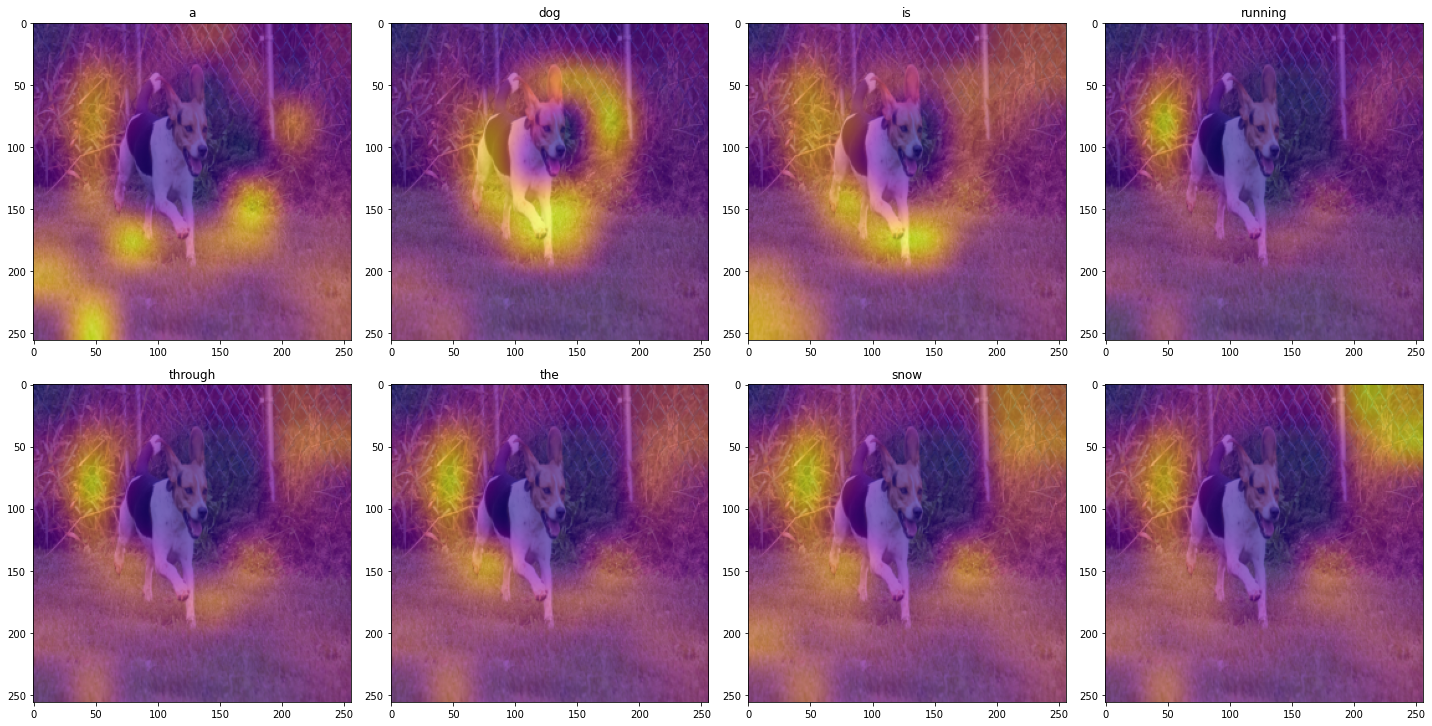

In [61]:
test_idx = 7
img = denormalize(np.array(test_data[0][test_idx].squeeze()), mean, std)
pred_cap = get_caption_back(out[test_idx], vocab_dict).split(" ")
plot_attention(img, pred_cap, alphas[test_idx].reshape((-1,8,8)))